In [2]:
!pip install medmnist

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 4.1 MB/s 
  Created wheel for fire: filename=fire-0.4.0-py2.py3-none-any.whl size=115942 sha256=f4f17f3aa54c27a1d3b7e6874414b62f46099d67c3c18ab38238c1f6ab75bf42
  Stored in directory: /root/.cache/pip/wheels/8a/67/fb/2e8a12fa16661b9d5af1f654bd199366799740a85c64981226
Successfully built fire


In [3]:
# https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import medmnist
from medmnist import INFO, Evaluator
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torchvision
import torch.nn.functional as F



In [5]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

pil_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)


  0%|          | 0/205615438 [00:00<?, ?it/s]

Using downloaded and verified file: /root/.medmnist/pathmnist.npz
Using downloaded and verified file: /root/.medmnist/pathmnist.npz


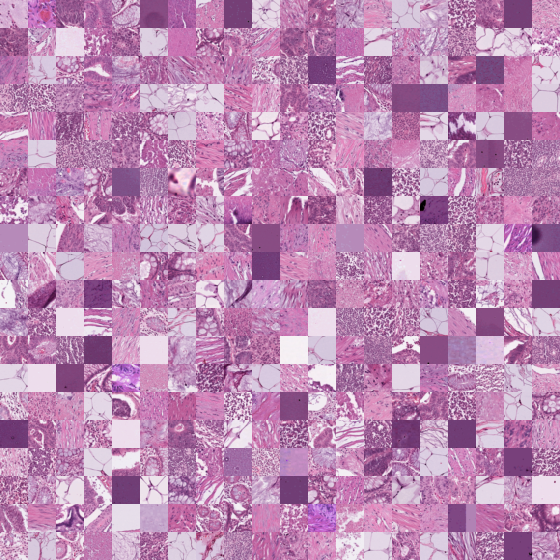

In [6]:
train_dataset.montage()

In [7]:
train_dataset.imgs.shape

(89996, 28, 28, 3)

In [18]:
# tutorial: https://avandekleut.github.io/vae/
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        # 28*28*3
        self.linear1 = nn.Linear(2352, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 512)
        self.linear2 = nn.Linear(512, 784)

    def forward(self, z):
        z = F.relu(self.linear1(z))
        z = torch.sigmoid(self.linear2(z))
        return z.reshape((-1, 1, 28, 28))


class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)

def train(autoencoder, data, epochs=5, lr=0.001):
    # only for fast training
    nsamples = 100
    opt = torch.optim.Adam(autoencoder.parameters(), lr=lr)
    for epoch in range(epochs):
        i = 0
        for x, y in data:
            if i > nsamples:
                break
            i= i + 1
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.encoder.kl
            loss.backward()
            opt.step()
    return autoencoder

In [19]:
def plot_latent(autoencoder, data, num_batches=100):
    for i, (x, y) in enumerate(data):
        z = autoencoder.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break
    plt.show()

In [24]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12, latent_dim=2):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.randint(-10,10, (1,latent_dim), dtype=torch.float, device=device)
            # z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            # print(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    plt.show()

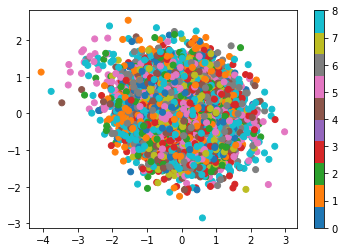

In [21]:
latent_dims = 32 #hyperparameter we can optimze?
vae = VariationalAutoencoder(latent_dims).to(device) # GPU

vae = train(vae, train_loader, lr=0.0001)
plot_latent(vae, train_loader)

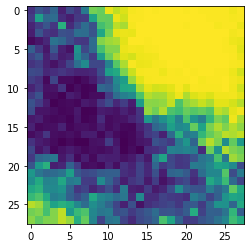

In [25]:
z = torch.randint(-10,10, (1,latent_dims), dtype=torch.float, device=device)
img = vae.decoder.forward(z)

plt.imshow(img.cpu().detach().numpy()[0,0])
plt.show()

tensor([[  5.,   1.,   2.,  -7.,   8.,  -2.,   7.,  -9.,  -7.,   0.,  -8.,   4.,
         -10.,  -1.,   7.,  -3.,  -7., -10.,  -3.,   4.,  -3.,  -8.,   8.,   1.,
          -4.,   2.,   1.,  -4.,  -9.,   5.,   1.,  -7.]], device='cuda:0')
tensor([[  9.,   6.,   6.,  -5.,   5.,   4.,   4.,  -7., -10.,  -1.,   6.,   4.,
           0.,   5.,   3.,  -4.,  -3.,  -9.,  -6.,   7.,   3.,  -4.,   5.,  -4.,
          -6., -10.,   0.,   8.,   8.,   8.,  -4.,  -1.]], device='cuda:0')
tensor([[  3.,  -8.,  -3.,  -5.,   7.,  -7.,   4.,   4.,   9.,   1., -10.,   8.,
           2.,   8.,  -7.,   8.,   2.,  -8.,  -6.,   9., -10.,   8.,   4.,   4.,
           7.,   3.,  -3.,  -4.,   6.,  -9.,  -5.,   3.]], device='cuda:0')
tensor([[  2.,  -7.,  -2.,   0.,  -3.,  -7.,   9., -10.,   6.,  -9.,  -1.,  -7.,
           5.,   8.,   4.,  -2.,   9.,   5.,   2.,  -4.,  -1.,  -9.,  -2.,   5.,
           7., -10.,   4.,   8.,  -8.,  -5.,  -7.,  -5.]], device='cuda:0')
tensor([[  6.,   1.,   2.,  -1.,   1.,  -9.,  -9

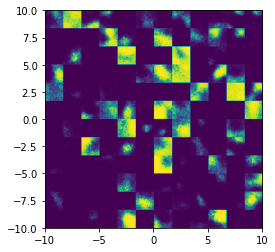

In [23]:
plot_reconstructed(vae, r0=(-10, 10), r1=(-10, 10), latent_dim=latent_dims)

# New Section